In [1]:
import os

import torch
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


%matplotlib inline

### Data preprocessing

In [2]:
class FermiDataset(Dataset):

    def __init__(self, images_path, points_path, transform=None):
        self.images_path = images_path
        self.points_path = points_path
        self.index = sorted(os.listdir(self.images_path))
        self.transform = transform
        
    def __len__(self):
        return len(self.index)

    def create_target(self, y):
        mask = np.zeros((200, 200), dtype=np.int32)
        for coord in y:
            mask[coord[0], coord[1]]=1
        return np.array(mask, dtype=np.int64)


    def __getitem__(self, idx):
        
        image = np.load(os.path.join(self.images_path, self.index[idx]))
        image = image.reshape(*image.shape, -1)
        points = np.load(os.path.join(self.points_path, self.index[idx]))
        mask = np.array(self.create_target(points)).reshape(*image.shape[:2])
        sample = tuple([image, mask])
        if self.transform:
            sample = self.transform(sample)

        return sample

class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample[0], sample[1]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        mask = mask[top: top + new_h,
                    left: left + new_w]

        return tuple([image, mask])

class OneHotEncoding(object):
    def __init__(self, num_classes):
        if isinstance(num_classes, int):
            self.num_classes = num_classes
        else:
            raise ValueError('Num classes should be of the "int" type')

    def __call__(self, sample):
        image, mask = sample[0], sample[1]
        mask = np.eye(self.num_classes)[mask]
        return tuple([image, mask])

class ToTensor(object):
    def __call__(self, sample):
        image, mask = sample[0], sample[1]
        image = image.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))
        return tuple([torch.from_numpy(image).to(torch.float32),
                      torch.from_numpy(mask).to(torch.float32)])

In [890]:
def show_fermi(ax, i, image, mask):
    ax[0][i].imshow(image.reshape(image.shape[:2]))
    ax[1][i].imshow(mask.reshape(image.shape[:2]))

In [891]:
data_transform = transforms.Compose([
        RandomCrop(40),
        OneHotEncoding(2),
        ToTensor()
])

dset = FermiDataset(images_path='./../train_data/x',
                    points_path='./../train_data/y', transform=data_transform)

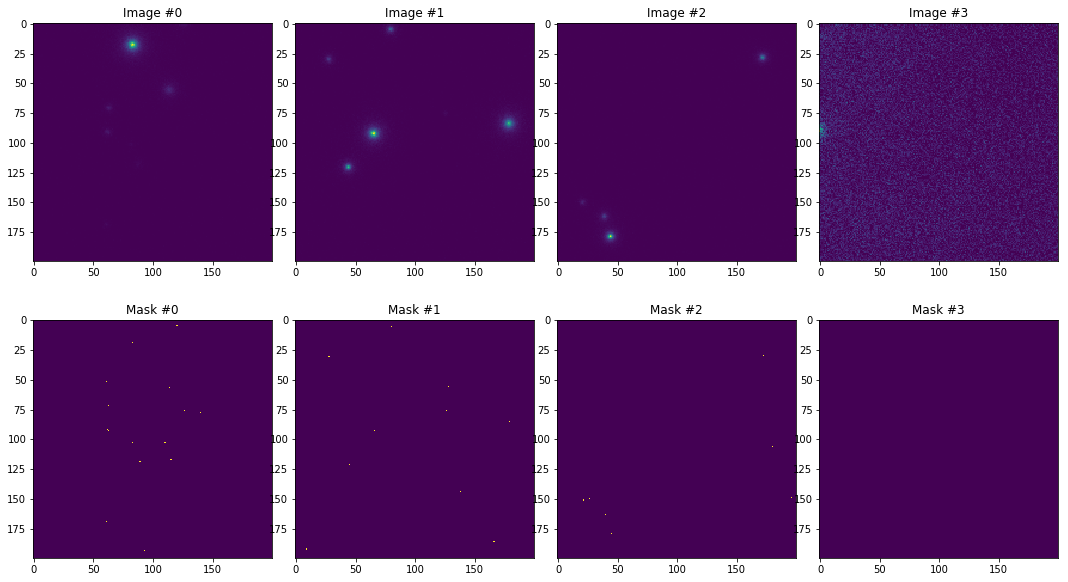

In [888]:
data_transform = transforms.Compose([
        RandomCrop(40),
        ToTensor()
])

dset = FermiDataset(images_path='./../train_data/x',
                    points_path='./../train_data/y')

_, ax = plt.subplots(2, 4, figsize=(15, 15))
for i in range(4):
    sample = dset[i]
    plt.tight_layout()
    ax[0][i].set_title('Image #{}'.format(i))
    ax[1][i].set_title('Mask #{}'.format(i))
    show_fermi(ax, i,  *sample)
    plt.subplots_adjust(wspace=0.1, hspace=-0.6)

In [3]:
SIZE = 100
data_transform = transforms.Compose([
        RandomCrop(SIZE),
        OneHotEncoding(2),
        ToTensor()
])

train_dataset = FermiDataset(images_path='./../train_data/x',
                             points_path='./../train_data/y',
                             transform=data_transform)
test_dataset = FermiDataset(images_path='./../test_data/x',
                            points_path='./../test_data/y',
                            transform=data_transform)

data_loader = {phase: torch.utils.data.DataLoader(dataset,
                                                  batch_size=20, shuffle=True,
                                                  num_workers=4)
               for phase, dataset in zip(['train', 'test'], [train_dataset, test_dataset])}

dataset_sizes = {phase: len(dataset) for phase, dataset in zip(['train', 'test'], 
                                                               [train_dataset, test_dataset])}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Model initialization

In [4]:
class ConvNet(nn.Module):
    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1)

    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.conv6(x)
#         assert x.requires_grad, "must be a torch tensor with grad"
        return x

### Training process

In [5]:
from tqdm import tqdm
global_loss = []
model = ConvNet()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1., 20.]))
num_epochs = 3

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'test']:
        if phase == 'train':
#             scheduler.step()
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        runnign_acc = 0.0

        for inputs, labels in data_loader[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                outputs = outputs.transpose(3, 1)
                labels = labels.transpose(3, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
            running_loss += loss.item() * inputs.size(0)
            global_loss.append(loss)
#             running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
#         epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, 0))#, epoch_acc))
        # deep copy the model
#         if phase == 'test' and epoch_acc > best_acc:
#             best_acc = epoch_acc
#             best_model_wts = copy.deepcopy(model.state_dict())

Epoch 0/2
----------
train Loss: 66.8046 Acc: 0.0000
test Loss: 0.0458 Acc: 0.0000
Epoch 1/2
----------
train Loss: 0.3049 Acc: 0.0000
test Loss: 0.0458 Acc: 0.0000
Epoch 2/2
----------
train Loss: 0.0264 Acc: 0.0000
test Loss: 0.0217 Acc: 0.0000


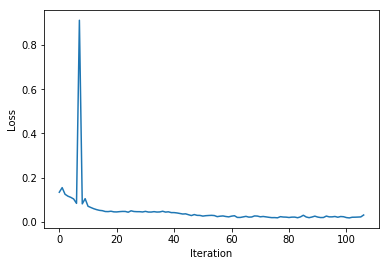

In [40]:
plt.plot(global_loss[100:])
plt.xlabel('Iteration')
plt.ylabel('Loss');

In [6]:
model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loader['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

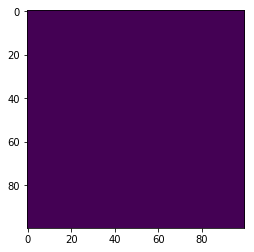

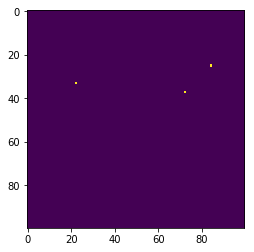

In [34]:
i = 6
img = (outputs.transpose(3, 1)[i][:,:,1] > 0.5).reshape(-1, SIZE)
plt.imshow(img)
plt.show()
plt.imshow(labels.transpose(3, 1)[i][:,:,1].reshape(-1, SIZE))